<a href="https://colab.research.google.com/github/umitkacar/genai-tutorials/blob/main/notebooks/gemini-object-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bounding box and object detection with Gemini

<a target="_blank" href="https://colab.research.google.com/github/patrickloeber/genai-tutorials/blob/main/notebooks/gemini-object-detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[Gemini 2.0 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-2.0-flash) and [Gemini 2.5 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25) can be used for object and bounding box detection. This notebook shows you how.

Download an example image, or use just a local one: `image = Image.open("file.png")`

(1408, 768)


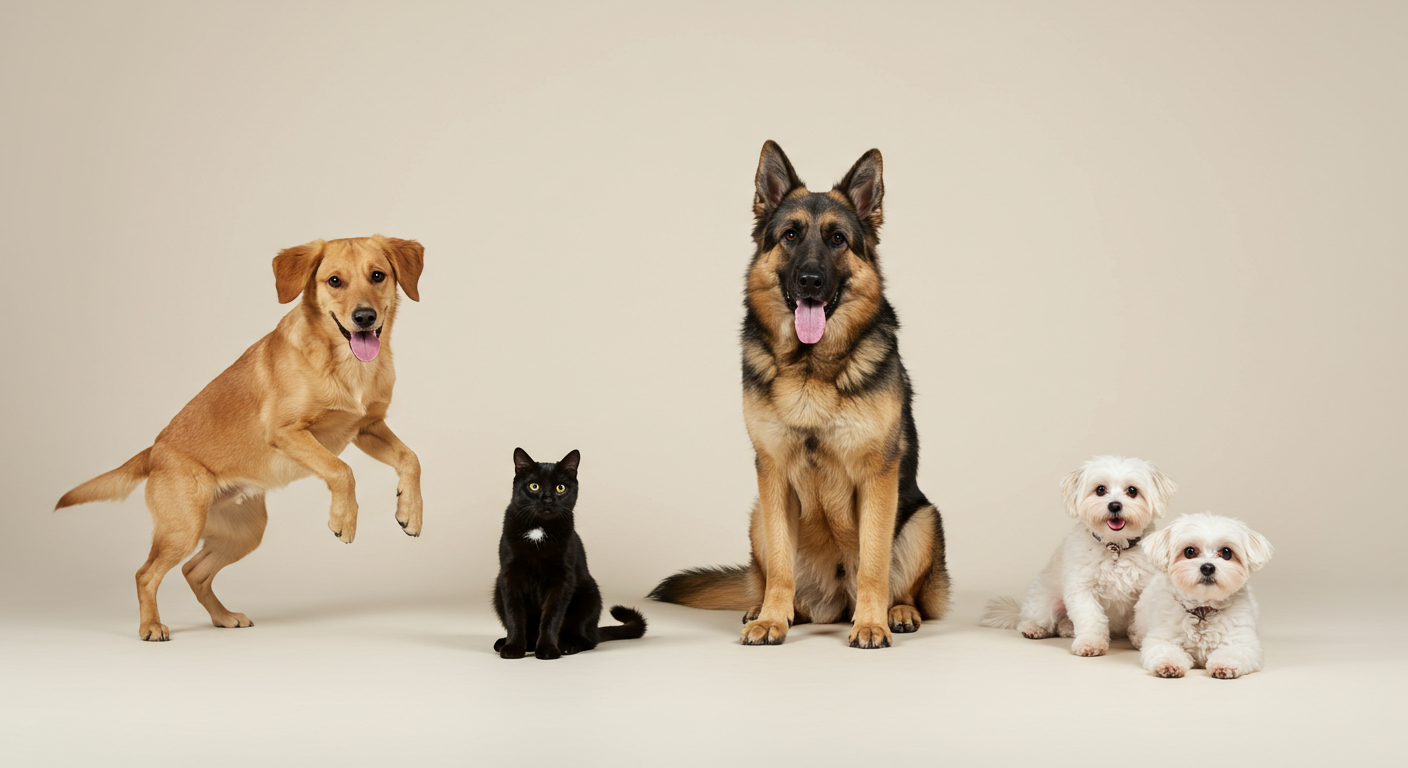

In [ ]:
import requests
from io import BytesIO
from PIL import Image   # for local envs, install Pillow with `pip install Pillow`
url = 'https://raw.githubusercontent.com/patrickloeber/genai-tutorials/main/data/animals.png'
image = Image.open(BytesIO(requests.get(url).content))
print(image.size)
image

## Get Started with Gemini

To get started, install the [google-genai](https://github.com/googleapis/python-genai) Python SDK and obtain a [free API key](https://aistudio.google.com/app/apikey) in AI Studio.

In [ ]:
%pip install -U -q google-genai
# already installed in Colab, but for local env: pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [ ]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

## Detect bounding boxes

Define the bounding box schema.

**Important**: Gemini returns bounding box coordinates in this format:
- `[y_min, x_min, y_max, x_max]`
- and normalized to `[0,1000]`

In [ ]:
# Define the bounding box schema.
from pydantic import BaseModel

class BoundingBox(BaseModel):
  box_2d: list[int]
  label: str

Define the prompt. Here we also want the label:

In [ ]:
prompt = """Detect the 2d bounding boxes of all tails of animals.
The corresponding label should be the animal type"""

Run the model. `gemini-2.5-pro-exp-03-25` is very good, `gemini-2.0-flash` works also well and is faster.

In [ ]:
response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25", # "gemini-2.0-flash"
    contents=[prompt, image],
    config={
        'response_mime_type': 'application/json',
        'response_schema': list[BoundingBox],
    },

)

# Parse the JSON response
bounding_boxes = response.parsed
bounding_boxes

[BoundingBox(box_2d=[337, 214, 373, 240], label='dog'),
 BoundingBox(box_2d=[343, 259, 378, 283], label='dog'),
 BoundingBox(box_2d=[613, 365, 641, 383], label='cat'),
 BoundingBox(box_2d=[616, 391, 643, 409], label='cat'),
 BoundingBox(box_2d=[296, 549, 327, 570], label='dog'),
 BoundingBox(box_2d=[300, 591, 330, 612], label='dog'),
 BoundingBox(box_2d=[643, 777, 661, 792], label='dog'),
 BoundingBox(box_2d=[645, 798, 663, 812], label='dog'),
 BoundingBox(box_2d=[707, 835, 728, 852], label='dog'),
 BoundingBox(box_2d=[710, 864, 731, 880], label='dog')]

Draw the bounding boxes:

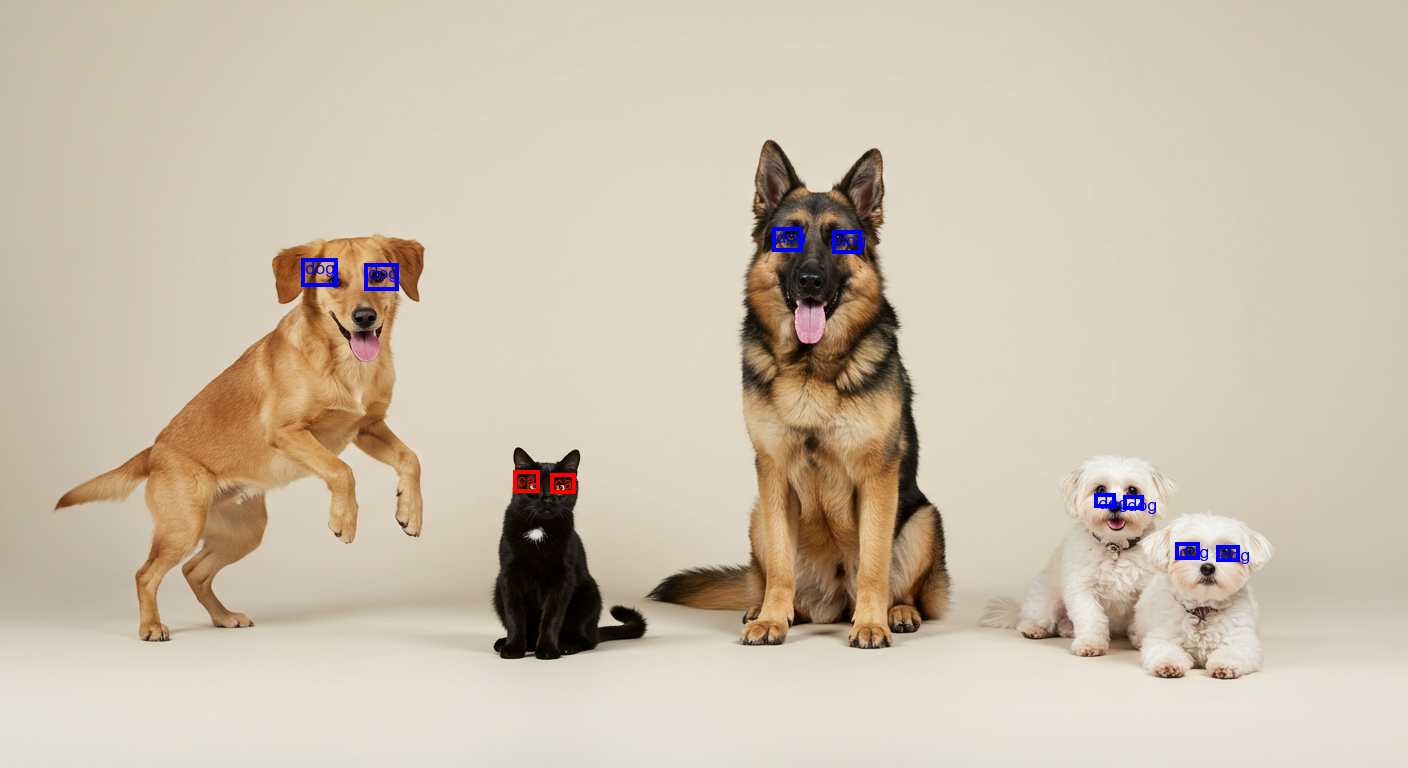

In [ ]:
from PIL import ImageDraw, ImageFont

line_width = 4
font = ImageFont.load_default(size=16)

labels = list(set(box.label for box in bounding_boxes))

def draw_bounding_boxes(image, bounding_boxes):
    img = image.copy()
    width, height = img.size

    draw = ImageDraw.Draw(img)

    colors = ['blue','red','green','yellow','orange','pink','purple']

    for box in bounding_boxes:
        y_min, x_min, y_max, x_max = box.box_2d
        label = box.label

        # Convert normalized coordinates to absolute coordinates
        y_min = int(y_min/1000 * height)
        x_min = int(x_min/1000 * width)
        y_max = int(y_max/1000 * height)
        x_max = int(x_max/1000 * width)

        color = colors[labels.index(label) % len(colors)]
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)

        draw.text((x_min+line_width, y_min), label, fill=color, font=font)

    display(img)

draw_bounding_boxes(image, bounding_boxes)